# Introduction

This notebook is going to cover the basics of how to use Stable Diffusion to create and modify images using existing pipelines. We'll also take a brief look at the key components within the pipeline, while leaving further exploration of them to the deep dive notebook. Specifically, we will cover:
- Generating images from text using the `StableDiffusionPipeline` and experimenting with the available arguments
- Seeing some of the key pipeline components in action
    - The VAE that makes this a 'latent diffusion model'
    - The tokenizer and text encoder that process the text prompt
    - The UNet itself
    - The scheduler, and exploring different schedulers
- Replicating the sampling loop with the pipeline components
- Editing existing images with the Img2Img pipeline
- Using inpainting and Depth2Img pipelines

❓If you have any questions, please post them on the `#diffusion-models-class` channel on the Hugging Face Discord server. If you haven't signed up yet, you can do so here: https://huggingface.co/join/discord


# Setup

In [ ]:
!pip install -Uq diffusers ftfy accelerate

     |████████████████████████████████| 524 kB 27.4 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 191 kB 73.0 MB/s 
     |████████████████████████████████| 182 kB 52.7 MB/s 


In [ ]:
# Installing transformers from source for now since we need the latest version for Depth2Img:
!pip install -Uq git+https://github.com/huggingface/transformers 

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.6 MB 30.4 MB/s 


In [ ]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
    )       

# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

In [ ]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

# Generating Images from Text

Let's load a Stable Diffusion pipeline and see what it can do. There are multiple different versions of Stable Diffusion, with the latest at the time of writing being version 2.1. If you'd like to explore an older version, simply replace the model ID with the appropriate model (for example, you could try "CompVis/stable-diffusion-v1-4" or pick a model from the [dreambooth concepts library](https://huggingface.co/sd-dreambooth-library)).

In [ ]:
# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

If you're running out of GPU memory, there are some things you can do to reduce the RAM usage:
- Load the FP16 version (not supported on all systems). With this you may also need to convert tensors to torch.float16 when experimenting with individual components of the pipeline:

  `pipe = StableDiffusionPipeline.from_pretrained(model_id, revision="fp16", torch_dtype=torch.float16).to(device)`

- Enable attention slicing. This reduces GPU memory usage at the cost of a small reduction in speed:

 `pipe.enable_attention_slicing()`
- Reduce the size of the images you're generating

Once the pipeline is loaded, we can generate an image based on a prompt with the following code:

  0%|          | 0/35 [00:00<?, ?it/s]

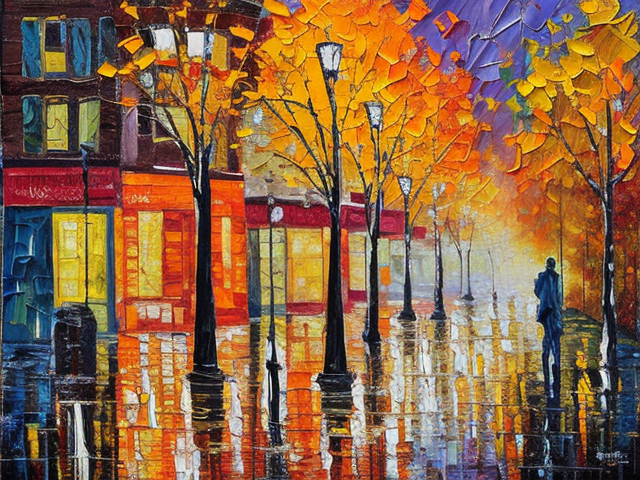

In [ ]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=480, width=640,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image:
pipe_output.images[0]

**Exercise:** Spend some time playing with the cell above, using your own prompts and tweaking settings to see how they affect the output. Use a different random seed or remove the `generator` argument to get different results each time.

Key arguments to tweak:
- Width and height specify the size of the generated image. They must be divisible by **8** for the VAE to work (which we'll see in a future section).
- The number of steps influences the generation quality. The default (50) works well, but in some cases you can get away with as few as 20 steps which is handy for experimentation.
- The negative prompt is used during the classifier-free guidance process, and can be a useful way to add additional control. You can leave it out, but many users find it useful to list some undesirable descriptions in the negative prompt as shown above.
- The `guidance_scale` argument determines how strong the classifier-free guidance (CFG) is. Higher scales push the generated images to better match the prompt, but if the scale is too high the results can become over-saturated and unpleasant. 

If you're looking for prompt inspiration, the [Stable Diffusion Prompt Book](https://stability.ai/sdv2-prompt-book) is a good place to start.

You can see the effect of increasing the guidance scale in the following cell:

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

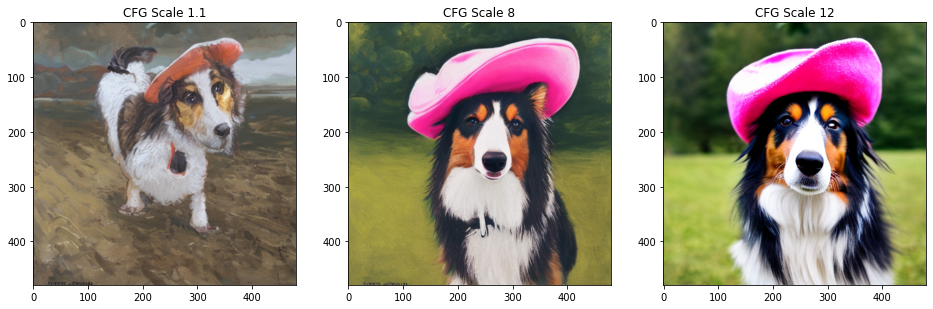

In [ ]:
#@markdown comparing guidance scales:
cfg_scales = [1.1, 8, 12] #@param
prompt = "A collie with a pink hat" #@param
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
  im = pipe(prompt, height=480, width=480,
    guidance_scale=cfg_scales[i], num_inference_steps=35,
    generator=torch.Generator(device=device).manual_seed(42)).images[0]
  ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}');

Tweak the values above to try different scales and prompts. Interpretation is subjective of course, but to my eye anything in the 8-12 range produces better results than values below or above this range.

# Pipeline Components

The `StableDiffusionPipeline` we're using is a little more complex than the `DDPMPipeline` we've explored in the previous units. In addition to the unet and the scheduler, there are a number of other components included in the pipeline:

In [ ]:
print(list(pipe.components.keys())) # List components

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor']


To better understand how the pipeline works, let's briefly see each component in action individually and then put them all together to replicate the functionality of the pipeline for ourselves.

### The VAE

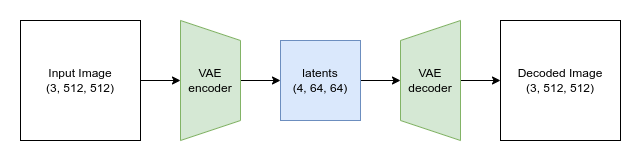

The VAE (variational autoencoder) is a type of model that can encode its input into a compressed representation and then decode this 'latent' representation back into something close to the original input. When generating images with stable diffusion, we first **generate the latents** by applying the diffusion process in the 'latent space' of the VAE, and then **decode them at the end** to view the resulting image.

Here is some code that takes an input image, encodes it to a latent representation and then decodes it again using the VAE:

In [ ]:
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1 
print("Input images shape:", images.shape)

# Encode to latent space
with torch.no_grad():
  latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
  decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


As you can see, the 512x512 image is compressed to a 64x64 latent representation (with four channels). This 8x reduction in each spatial dimension is the reason the specified width and height need to be multiples of 8.

Working with these information-rich 4x64x64 latents is more efficient than working with massive 512px images, allowing for faster diffusion models that take less resources to train and use. The VAE decoding process is not perfect, but it is good enough that the small quality tradeoff is generally worth it. 

NB: The code example above includes the scaling factor of 0.18215 required to match the processing used during SD's training. 

### The Tokenizer and Text Encoder


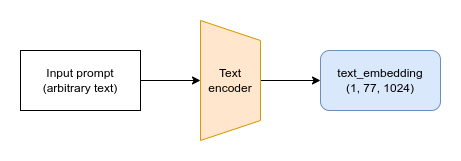


The goal of the text encoder is to turn an input string (the prompt) into a numerical representation that can be fed to the UNet as conditioning. The text is first turned into a series of tokens using the pipeline's tokenizer. The text encoder has a vocabulary of about 50k tokens - any word isn't in this vocabulary is split into smaller sub-words. The tokens are then fed through the text encoder model itself - a transformer model that was originally trained as the text encoder for CLIP. The hope is that this pretrained transformer model has learnt rich representations of text that will be useful for the diffusion task too.

Let's test out this process by encoding an example prompt ,first manually tokenizing and feeding it through the text encoder and then using the pipelines `_encode_prompt` method to show the full process including padding/truncating the length to the maximum length of 77 tokens:

In [ ]:
# Tokenizing and encoding an example prompt manualy:

# Tokenize
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
  text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])


In [ ]:
# Get the final text embeddings using the pipeline's _encode_prompt function:
text_embeddings = pipe._encode_prompt("A painting of a flooble", device, 1, False, '')
text_embeddings.shape

torch.Size([1, 77, 1024])

These text embeddings (the so-called 'hidden states' of the last transformer block in the text encoder model) will be fed to the UNet as an additional arument to the `forward` method, which we'll see in the next section.

### The UNet

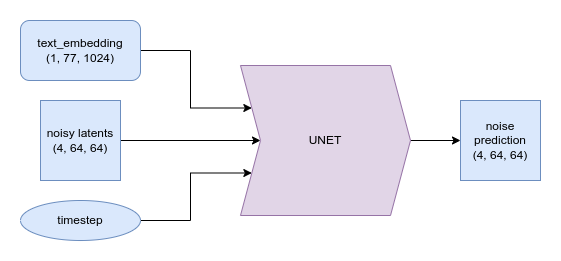

The UNet takes a noisy input and predicts the noise, just like the UNets we've seen in previous units. Unlike those previous examples, the input is not an image but is instead a latent representation of an image. And in addition to the timestep conditioning, this UNet also takes in the text embeddings of the prompt as an additional input. Here it is making predictions on some dummy data:

In [ ]:
# Dummy inputs:
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# Model prediction:
with torch.no_grad():
  unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape) # Same shape as the input latents

UNet output shape: torch.Size([1, 4, 64, 64])


### The Scheduler

The scheduler stores the noise schedule and manages updating the noisy sample based on the model predictions. The default scheduler is a `PNDMScheduler`, but you can use others (such as `LMSDiscreteScheduler`) as long as they are initialized with the same configuration.

We can plot the noise schedule to see the noise level (based on $\bar{\alpha}$) over time:

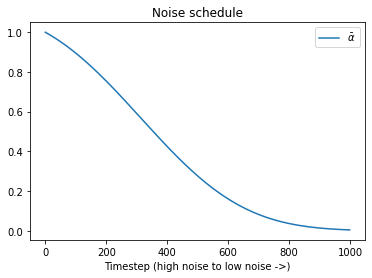

In [ ]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)');
plt.title('Noise schedule');plt.legend();

If you want to try out a different scheduler, you can swap in a new one as follows:

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.11.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "trained_betas": null
}



  0%|          | 0/50 [00:00<?, ?it/s]

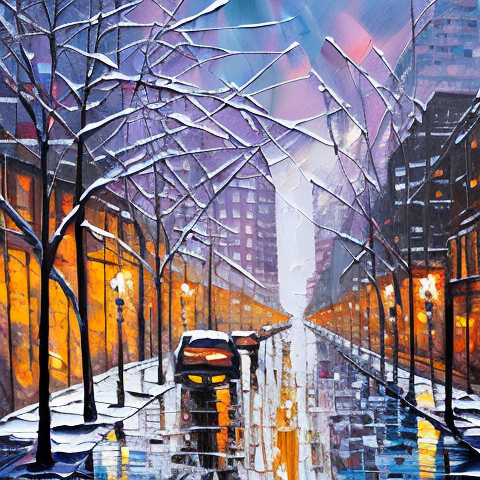

In [ ]:
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print('Scheduler config:', pipe.scheduler)

# Generate an image with this new scheduler
pipe(prompt="Palette knife painting of an winter cityscape", height=480, width=480,
     generator=torch.Generator(device=device).manual_seed(42)).images[0]

You can read more on using different schedulers [here](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion_2#how-to-load-and-use-different-schedulers).

### A DIY Sampling Loop

Now that we've seen all these components in action, we can put them together to replicate the functionality of the pipeline:

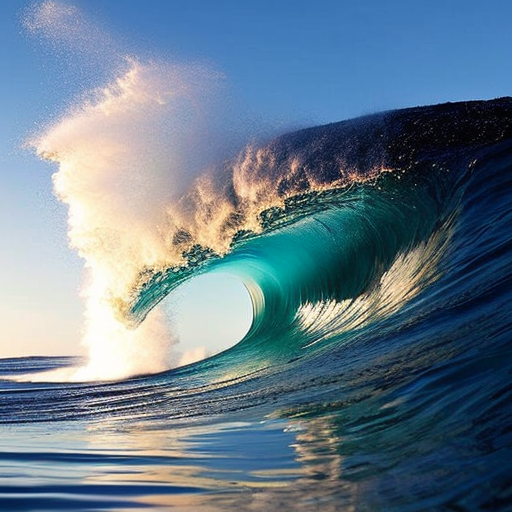

In [ ]:
guidance_scale = 8 #@param
num_inference_steps=30 #@param
prompt = "Beautiful picture of a wave breaking" #@param
negative_prompt = "zoomed in, blurry, oversaturated, warped" #@param

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Loop through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):

  # expand the latents if we are doing classifier free guidance
  latent_model_input = torch.cat([latents] * 2)

  # Apply any scaling required by the scheduler
  latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual with the unet
  with torch.no_grad():
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
  image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]

In most cases it will be easier to use the existing pipelines, but having this hackable sampling loop can be useful for understanding and modifying how each component works. If you'd like to see this code and all the different components explored and modified in depth, check out the 'Stable Diffusion Deep Dive' [notebook](https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb) and [video](https://m.youtube.com/watch?v=0_BBRNYInx8) for a more thorough exploration.

# Additonal Pipelines

So what can we do besides just generating images from a prompt? Quite a lot! In this section we'll demonstrate a few cool pipelines to give you a taste of some of the other tasks that Stable Diffusion can be used for. Several of these require downloading new models, so if you're in a hurry you can skim through this section just looking at the existing outputs rather than downloading and running all of the models yourself.

## Img2Img

In the examples so far we've generated images completely from scratch by starting from random latents and applying the full diffusion sampling loop. But we don't have to start from scratch. The Img2Img pipeline first encodes an existing image into a set of latents, then adds some noise to the latents and uses that as the starting point. The amount of noise added and the number of denoising steps applied determine the 'strength' of the img2img process. Adding just a small amount of noise (low strength) will result in very little change, while adding the maximum amount of noise and running the full denoising process will give an image that hardly resembles the input apart from some similarities on overall structure. 

This pipeline requires no special models, and so as long as the model ID is the same as our text-to-image example above no new files will need to be downloaded. Since we already have a pipeline loaded, we can even initialize the Img2Img pipeline with the components of the base pipeline as follows:

In [ ]:
# Loading an Img2Img pipeline based on the currently loaded pipeline
img2img_pipe = StableDiffusionImg2ImgPipeline(**pipe.components)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In the 'Setup' section we loaded an example `init_image` to use for this demo, but you can replace it with your own image if you'd prefer. Here's the pipeline in  action:

  0%|          | 0/30 [00:00<?, ?it/s]

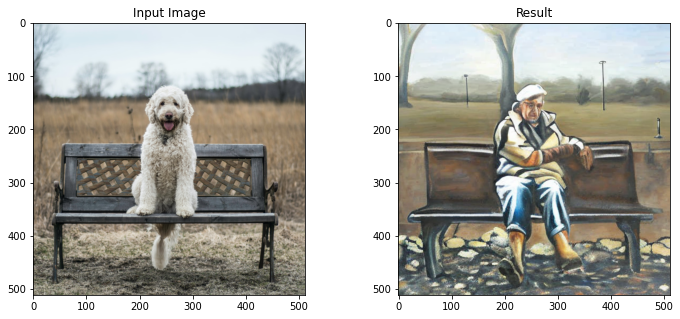

In [ ]:
# Apply Img2Img
result_image = img2img_pipe(
    prompt="An oil painting of a man on a bench",
    image = init_image, # The starting image
    strength = 0.6, # 0 for no change, 1.0 for max strength
).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(result_image);axs[1].set_title('Result');

**Exercise:** Experiment with this pipeline. Try your own images, or play with different strengths and prompts. You can use many of the same arguments as the text-to-image pipeline, so feel free to try different sizes, number of steps etc.

## In-Painting

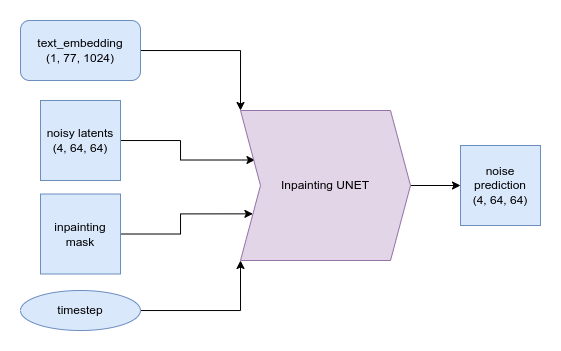

What if we wanted to keep some of the input image unchanged but generate something new in other parts? This is called 'inpainting'. While it can be done with the same model as the previous demos (via the `StableDiffusionInpaintPipelineLegacy`) we can get better results by using a custom fine-tuned version of Stable Diffusion that takes a mask as additional conditioning. The mask image should be the same shape as the input image, with white in the areas to be replaces and black in the areas to be kept unchanged. Here's how we load such a pipeline and apply it to the example image and mask loaded in the 'Setup' section:

In [ ]:
# Load the inpainting pipeline (requires a suitable inpainting model)
pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")
pipe = pipe.to(device)

  0%|          | 0/50 [00:00<?, ?it/s]

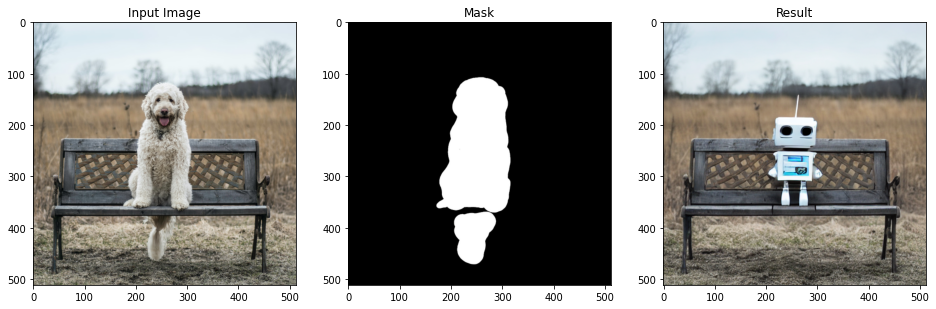

In [ ]:
# Inpaint with a prompt for what we want the result to look like
prompt = "A small robot, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

# View the result
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(mask_image);axs[1].set_title('Mask')
axs[2].imshow(image);axs[2].set_title('Result');

This can be especially powerful when combined with another model to automatically generate masks. For example, [this demo space](https://huggingface.co/spaces/nielsr/text-based-inpainting) uses a model called CLIPSeg to mask out an object to be replaced based on a text description.

### Aside: Managing Your Model Cache

Exploring different pipelines and model variants can fill up your disk space. You can see which models are currently downloaded with:

In [ ]:
!ls ~/.cache/huggingface/diffusers/ # List the contents of the cache directory

models--runwayml--stable-diffusion-inpainting
models--stabilityai--stable-diffusion-2-1-base


Check out [the docs on caching](https://huggingface.co/docs/huggingface_hub/main/en/how-to-cache) to see how to view and manage your cache effectively. 

## Depth2Image


![depth to image examples](https://camo.githubusercontent.com/5a7cd804dff6283157144f1d54b99a637195fcd25f10c7e9ab7952322d746269/68747470733a2f2f68756767696e67666163652e636f2f73746162696c69747961692f737461626c652d646966667573696f6e2d322d64657074682f7265736f6c76652f6d61696e2f646570746832696d6167652e706e67)
_Input image, depth image and generated examples (image source: StabilityAI)_

Img2Img is great, but sometimes we want to create a new image with the composition of the original but completely different colours or textures. It can be difficult to find an Img2Img strength that preserves what we'd like of the layout without also keeping the input colors. 

Time for another fine-tuned model! This one takes in depth information as additional conditioning when generating. The pipeline uses a depth estimation model to create a depth map, which is then fed to the fine-tuned UNet when generating images to (hopefully) preserve the depth and structure of the initial image while filling in completely new content.

In [ ]:
# Load the Depth2Img pipeline (requires a suitable model)
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-depth")
pipe = pipe.to(device)

  0%|          | 0/40 [00:00<?, ?it/s]

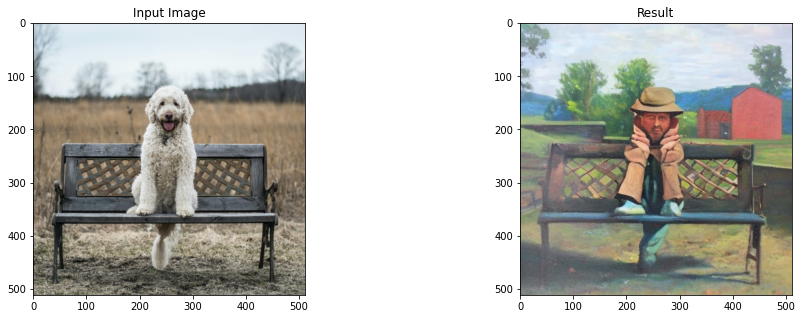

In [ ]:
# Inpaint with a prompt for what we want the result to look like
prompt = "An oil painting of a man on a bench"
image = pipe(prompt=prompt, image=init_image).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(image);axs[1].set_title('Result');

Note how the output compares to the img2img example - here there is much more color variation, but the overall structure is still faithful to the original. This is not ideal in this case since the man has been given some extremely weird anatomy to match the dog shape, but in some cases this is extraordinarily useful. For an example of the 'killer app' for this approach, check out [this tweet](https://twitter.com/CarsonKatri/status/1600248599254007810?s=20&t=BlzSK26sfqi2336SN0gKpQ) showing the depth model being used to texture a 3D scene!

# Where Next?

Hopefully this has given you a taste for the many this that Stable Diffusion can do! Once you get tired of playing with the examples in this notebook, check out the **DreamBooth hackathon** notebook to see how to fine-tune your own version of Stable Diffusion which can be used with the text-to-image or img2img pipelines we've seen here.

If you're curious to dig deeper into how the different components work, then check out the **Stable Diffusion Deep Dive** notebook which goes into much more detail and shows some additional tricks we can do.

Be sure to share your creations with us and the community! 